In [301]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [302]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree

In [303]:
from src.neuron_population import NeuronPopulation
from src.connectome import Connectome
from src.overhead import Simulation
from src.neuron_templates import neuron_type_IZ
from src.network_grower import *
from src.network_generators import *
from src.neuron_type_distributor import *
from src.network_weight_distributor import *
from src.external_inputs import *

In [304]:
weight_scale = 1.0
g = 1.2984752590298583 * 60

J_I = weight_scale * g
J_E = weight_scale
delay_mean_E = 10.0
delay_std_E = delay_mean_E * 0.5
delay_mean_I = 1.5
delay_std_I = delay_mean_I * 0.2
v_ext = 0.45527031369449

excitatory_type = "ss4"
inhibitory_type = "b"

In [305]:
seed = 1234

## Generate network

In [306]:
n_neurons = int(1000 * 1.0)

I_percent = 0.2

n_excitatory = int(n_neurons * (1 - I_percent))

density = 0.1

In [307]:
type_fractions = {
    "ss4": 0.8,
    "b": 0.2,
}

inhibitory_types = ("b")

p0_by_pair = {"EE": 0.5, "EI": 0.5, "IE": 0.5, "II": 0.5}

lambda_by_preclass = {"E": 0.2, "I": 0.05} # Distance factor

weight_dist_by_ntype={"ss4": "lognormal", "b": "normal"}

outdegree_config_by_type={
        # lognormal: params = (mu, sigma), then k = floor(exp(N(mu,sigma)))
        "ss4": {"dist": "lognormal", "params": (2.65, 0.8)},  # higher mean out-degree
        "b":   {"dist": "neg-bin", "params": (50, 40)},  # lower mean out-degree
    }

normalize_mode = "out"
# normalize_target = 20.0
normalize_target_out_E = 50.0
normalize_target_out_I = 1000.0

G = generate_spatial_ei_network(n_neurons=n_neurons, type_fractions=type_fractions,
                                inhibitory_types=inhibitory_types,
                                mu_E=0.0, sigma_E=1.6, mu_I=30.0, sigma_I=6.0,
                                p0_by_pair=p0_by_pair,
                                lambda_by_preclass=lambda_by_preclass,
                                distance_scale=20.0,
                                weight_dist_by_ntype=weight_dist_by_ntype,
                                outdegree_config_by_type=outdegree_config_by_type,
                                normalize_mode=normalize_mode,
                                normalize_target_out_E=normalize_target_out_E,
                                normalize_target_out_I=normalize_target_out_I,)

Text(0.5, 1.0, 'b Weight Distribution after Lognormal Redistribution')

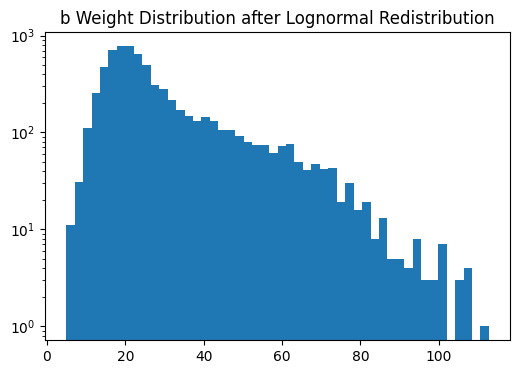

In [308]:
# Plot ss4 weight distribution
n_test_type = "b"
weights = [G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['ntype'] == n_test_type]
plt.figure(figsize=(6,4))
plt.hist(weights, bins=50, log=True)
plt.title(f"{n_test_type} Weight Distribution after Lognormal Redistribution")

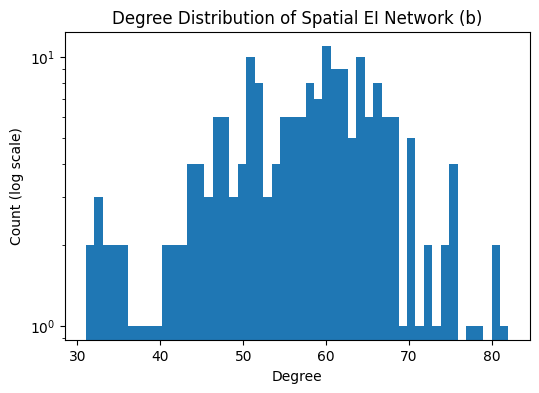

In [309]:
# Plot degree distribution
n_type_show = "b"
degrees = [G.degree(n) for n in G.nodes() if G.nodes[n]['ntype'] == n_type_show]
plt.figure(figsize=(6,4))
plt.hist(degrees, bins=50, log=True)
plt.title(f"Degree Distribution of Spatial EI Network ({n_type_show})")
plt.xlabel("Degree")
plt.ylabel("Count (log scale)")
plt.show()

In [310]:
enable_plot = False

if enable_plot:
    # Plot graph G using "pos" attribute for node positions
    pos = nx.get_node_attributes(G, 'pos')
    # Edge thinckness proportional to weight
    edges = G.edges()
    weights = [G[u][v]['weight'] / 2.0 for u, v in edges]
    # Node size proportional to degree
    degrees = [G.degree(n) for n in G.nodes()]
    # Node color by neuron type
    ntypes = nx.get_node_attributes(G, 'ntype')
    # Map neuron types to colors
    color_map = {'ss4': 'blue', 'b': 'red'}
    node_colors = [color_map.get(ntypes[n], 'gray') for n in G.nodes()]
    # Edge alpha
    alphas = [0.2 + 0.8 * G[u][v]['weight'] / 10.0 for u, v in edges]
    plt.figure(figsize=(8,8))
    nx.draw(G, pos, node_size=degrees, width=weights, edge_cmap=plt.cm.viridis, node_color=node_colors, alpha=0.65, with_labels=False)
    plt.title("Spatial EI Network Visualization")
    plt.show()

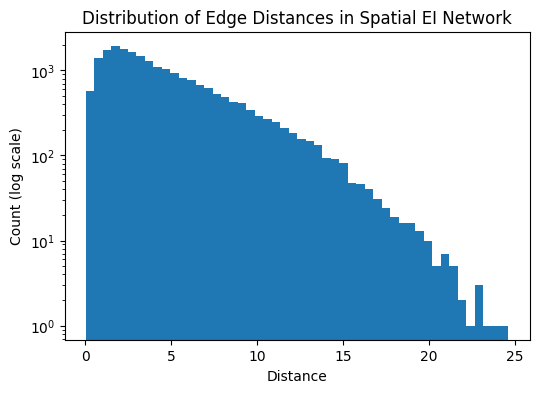

In [311]:
# Print distribution of "distance" attribute for edges
distances = [G[u][v]['distance'] for u, v in G.edges()]
plt.figure(figsize=(6,4))
plt.hist(distances, bins=50, log=True)
plt.title("Distribution of Edge Distances in Spatial EI Network")
plt.xlabel("Distance")
plt.ylabel("Count (log scale)")
plt.show()

## Simulation setup

In [312]:
dt = 0.1

In [313]:
# Neuron population parameters
n_neurons = G.number_of_nodes()
neuron_types = [excitatory_type, inhibitory_type]
n_neuron_types = len(neuron_types)
inhibitory = [False, True]
threshold_decay = np.exp(-dt / 5)

pop = NeuronPopulation(n_neurons, neuron_types, inhibitory, threshold_decay)

In [314]:
# Connectome
# Max number of outgoing synapses per neuron
max_synapses = max(dict(G.out_degree()).values())

connectome = Connectome(max_synapses, pop)

connectome.nx_to_connectome(G)

In [315]:
nmda_weight = np.ones(connectome.neuron_population.n_neurons, dtype=float)
nmda_weight[pop.inhibitory_mask.astype(bool)] = 0.959685703507305 * 0.5
# Invert to make excitatory neurons have NMDA weight 1, inhibitory 0
# nmda_weight

In [316]:
connectome.compute_metrics(small_world=False)

{'spectral_radius': 247.40335551358467,
 'n_nodes': 1000,
 'n_edges': 22136,
 'n_E': 800,
 'n_I': 200,
 'k_in_mean': 22.136,
 'k_out_mean': 22.136,
 's_in_mean': 240.0,
 's_out_mean': 240.0,
 'k_in_std': 5.882865977745211,
 'k_out_std': 17.328294023757035,
 's_in_std': 91.0077310275182,
 's_out_std': 380.190142618854,
 'edge_frac_EE': 0.5466660643295989,
 'edge_frac_EI': 0.14112757499096495,
 'edge_frac_IE': 0.25162631008312253,
 'edge_frac_II': 0.060580050596313696,
 'reciprocity': 0.08754969280809541,
 'assort_out_to_in_degree': 0.01922395946407685,
 'assort_outStrength_to_inStrength': 0.12402887634695053,
 'clustering_avg_weighted': 0.011213422694747155,
 'transitivity_unweighted': 0.12229828836481962,
 'rich_club_phi_k': 0.12605811027224892,
 'rich_club_k_sel': 62,
 'triadic_census': {'003': 146021331,
  '012': 18333231,
  '102': 875047,
  '021D': 290793,
  '021U': 180355,
  '021C': 345823,
  '111D': 28751,
  '111U': 48135,
  '030T': 27441,
  '030C': 4250,
  '201': 1928,
  '120D': 

## Simulation

100%|██████████| 15000/15000 [00:26<00:00, 560.33it/s]


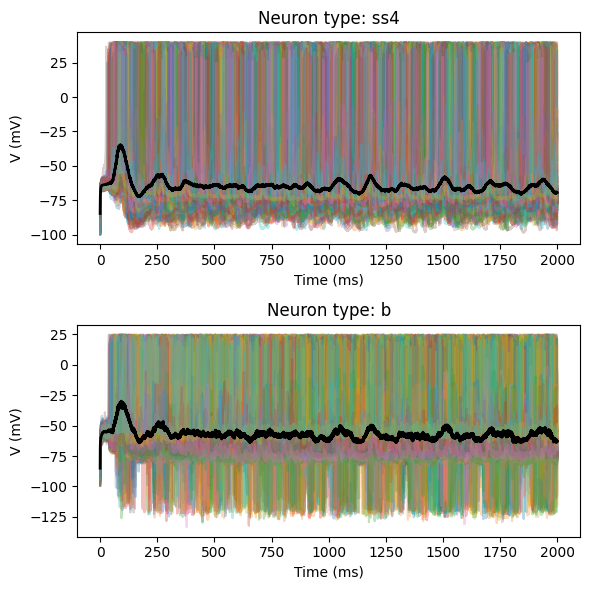

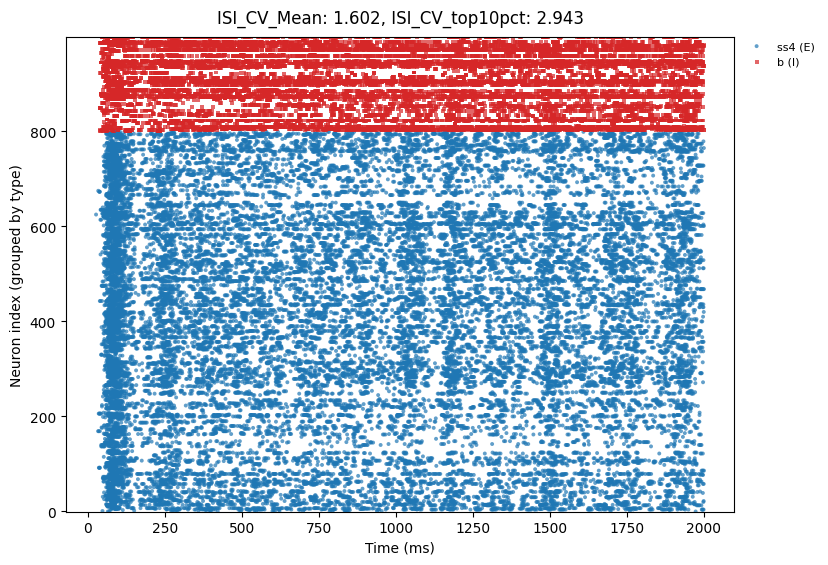

In [317]:

# Randomize initial voltages
Vs = rng.uniform(-100, -70, size=n_neurons)
us = rng.uniform(0, 400, size=n_neurons)
spikes = np.zeros(n_neurons, dtype=bool)
Ts = np.zeros_like(spikes)

state0 = (Vs,
          us,
          spikes.copy(),
          Ts.copy())

# sim = Simulation(connectome, dt, stepper_type="simple", state0=state0,
#                  enable_plasticity=False)
sim = Simulation(connectome, dt, stepper_type="euler_det", state0=state0,
                 enable_plasticity=False, synapse_kwargs={"LT_scale": 1.0, "NMDA_weight": nmda_weight}, synapse_type="standard",
                 enable_debug_logger=True)

# rate = np.zeros(n_neurons)
poisson = PoissonInput(n_neurons, rate=v_ext, amplitude=2.44625509556019 * 0.25)

from tqdm import tqdm

for i in tqdm(range(5000)):
    sensory_spikes = poisson(dt)
    sensory_spikes[pop.inhibitory_mask.astype(bool)] = False
    sim.step(spike_ext=sensory_spikes)
    # sim.step()

for i in tqdm(range(15000)):
    sim.step()

sim.plot_voltage_per_type(figsize=(6, 6))

stats = sim.stats.compute_metrics(dt, bin_ms_participation=300)

isi_mean = stats['ISI_CV_mean']
isi_top = stats["ISI_CV_mean_top10pct"]

sim.plot_spike_raster(figsize=(10, 6), title=f"ISI_CV_Mean: {isi_mean:.3f}, ISI_CV_top10pct: {isi_top:.3f}", t_start_ms=0.0, t_stop_ms=9000.0)

In [322]:
sim.stats.compute_metrics(dt, bin_ms_participation=300, t_start_ms=250.0, t_stop_ms=2000.0)

{'rate_mean_Hz': 23.80228571428571,
 'rate_median_Hz': 4.571428571428571,
 'rate_p95_Hz': 90.3428571428571,
 'rate_mean_Hz_E': 18.025,
 'rate_mean_Hz_I': 46.911428571428566,
 'rate_mean_Hz_E_active2spk': 26.921228304405872,
 'rate_mean_Hz_I_active2spk': 95.7201166180758,
 'ISI_CV_median': 1.4426683720949085,
 'ISI_CV_mean': 1.4939384703891172,
 'ISI_CV_mean_E': 1.426351485859204,
 'ISI_CV_mean_I': 1.861352822461306,
 'ISI_CV_mean_top10pct': 2.585596888264092,
 'refractory_violations_per_neuron': 2.453,
 'Fano_median_2ms': 0.9782608695652024,
 'Fano_median_10ms': 1.6382945305067436,
 'Fano_median_50ms': 1.9259790637122052,
 'Fano_median_100ms': 1.590277777777777,
 'Fano_median_300ms': 1.9809322033898304,
 'Fano_median_500ms': 2.0000000000000004,
 'Fano_median_1000ms': 0.0,
 'mean_noise_corr_2ms': 0.0022276987961504487,
 'mean_noise_corr_10ms': 0.006194741711107136,
 'mean_noise_corr_50ms': 0.016971831760713058,
 'mean_noise_corr_100ms': 0.01654865622633571,
 'mean_noise_corr_300ms': 0.0

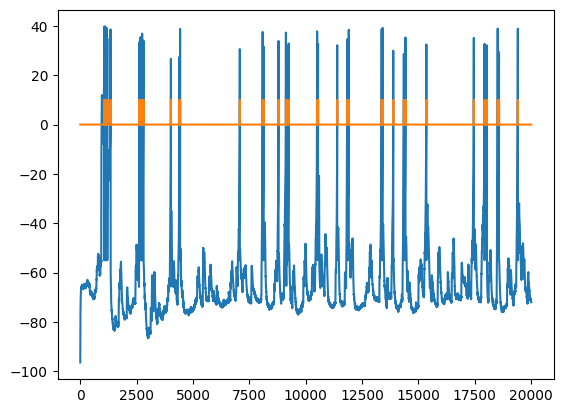

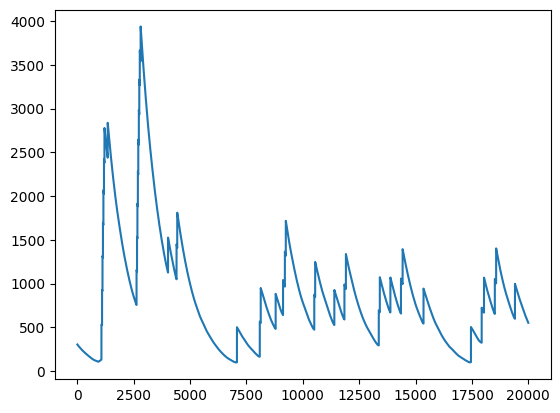

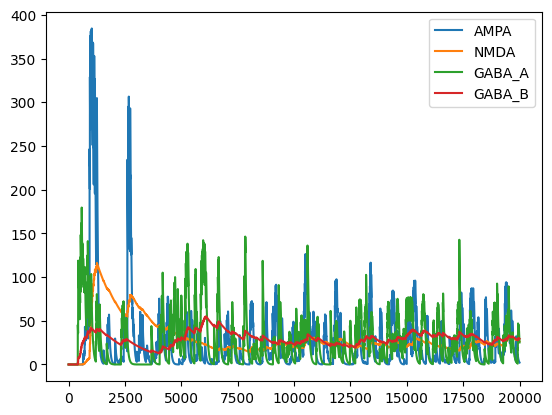

In [319]:
# Plot spikes for one neuron
n_idx = 734
t_first = 0
t_last = -1
plt.plot(np.array(sim.stats.Vs)[t_first:t_last,n_idx])
plt.plot(np.array(sim.stats.spikes)[t_first:t_last,n_idx] * 10)
plt.show()
plt.plot(np.array(sim.stats.us)[t_first:t_last,n_idx])
plt.show()
plt.plot(np.array(sim.debug_logger.s_ampa)[t_first:t_last,n_idx], label="AMPA")
plt.plot(np.array(sim.debug_logger.s_nmda)[t_first:t_last,n_idx], label="NMDA")
plt.plot(np.array(sim.debug_logger.s_gaba_a)[t_first:t_last,n_idx], label="GABA_A")
plt.plot(np.array(sim.debug_logger.s_gaba_b)[t_first:t_last,n_idx], label="GABA_B")
plt.legend()
plt.show()

In [320]:
# plt.plot(np.array(sim.debug_logger.s_ampa)[t_first:t_last,n_idx], label="AMPA")
# plt.plot(np.array(sim.debug_logger.s_nmda)[t_first:t_last,n_idx], label="NMDA")
# plt.plot(np.array(sim.debug_logger.s_gaba_a)[t_first:t_last,n_idx], label="GABA_A")
# plt.plot(np.array(sim.debug_logger.s_gaba_b)[t_first:t_last,n_idx], label="GABA_B")
# plt.legend()
# plt.show()

In [321]:
# connectome.compute_metrics(small_world=False)